In [11]:
import pyterrier as pt
import ir_datasets
import os
import matplotlib.pyplot as plt

In [12]:
# pt.init()

In [13]:
ds = pt.get_dataset("irds:disks45/nocr/trec-robust-2004")
print(ds)

INDEX_DIR = "./robust04_index_customfeatures"
os.makedirs(INDEX_DIR, exist_ok=True)

INDEX_DIR = os.path.abspath("./robust04_index_customfeatures")

IRDSDataset('disks45/nocr/trec-robust-2004')


## new index part

In [14]:
META_FIELD_LENGTHS = {"docno": 20, "body": 10000}
INDEXER_PROPERTIES = {"meta.reverse.keys": "docno,body"}

indexer = pt.IterDictIndexer(
    INDEX_DIR,
    text_attrs = ['body'],
    meta = META_FIELD_LENGTHS,
    properties = INDEXER_PROPERTIES
)

index_ref = indexer.index(ds.get_corpus_iter())

print("Finished")









































































disks45/nocr/trec-robust-2004 documents:   0%|          | 0/528155 [02:20<?, ?it/s]














































































































































































































































































































































































































































































































































































































































































































































































































































































16:12:24.150 [main] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (FR940104-2-00103) - further warnings are suppressed


16:21:12.121 [main] WARN org.terrier.structures.indexing.Indexer -- skipping null document
16:21:39.370 [main] WARN org.terrier.structures.indexing.Indexer -- Indexed 126 empty documents
Finished


In [15]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics())

16:21:39.884 [main] WARN org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 673,3 MiB of memory would be required.
Number of documents: 527970
Number of terms: 518597
Number of postings: 81882805
Number of fields: 0
Number of tokens: 141200305
Field names: []
Positions:   false



In [16]:
meta_index = index.getMetaIndex()

print(meta_index.getKeys())
print(list(meta_index.getReverseKeys()))

['docno', 'body']
['docno']


## XG Boost Part

In [17]:
import os
import pyterrier as pt
import pandas as pd
import xgboost as xgb
import re

In [18]:
#Function 1
def count_term_in_body_unique(row, meta_index):
    """
    Counts how many unique terms in the query appear in the document body.
    """
    docno = row["docno"]
    docid = meta_index.getDocument("docno", docno)

    if docid == -1:
        return 0

    body = meta_index.getItem("body", docid)

    body_terms = set(body.lower().split())
    query_terms = set(row["query"].lower().split())

    count = sum(1 for term in query_terms if term in body_terms)
    return count

In [19]:
#Function 2
def count_term_in_body_full(row, meta_index):
    """
    Counts the total occurrences of query terms in the document body.
    """
    docno = row["docno"]
    docid = meta_index.getDocument("docno", docno)

    if docid == -1:
        return 0

    body = meta_index.getItem("body", docid) or ""

    body_terms = body.lower().split()
    query_terms = row["query"].lower().split()

    # Count total occurrences
    count = sum(body_terms.count(term) for term in query_terms)
    return count

In [20]:
#Function3 
def query_coverage_first_200(row, meta_index):
    docno = row["docno"]
    docid = meta_index.getDocument("docno", docno)
    if docid == -1:
        return 0.0
    
    body = meta_index.getItem("body", docid) or ""

    body_terms = body.lower().split()[:200]
    query_terms = row["query"].lower().split()
    if not query_terms:
        return 0.0
    
    matched_terms = sum(1 for term in query_terms if term in body_terms)
    return float(matched_terms / len(query_terms))


In [21]:
import numpy as np
def cosine_sim(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-12))

In [22]:
from sentence_transformers import SentenceTransformer

sbert_minilm = SentenceTransformer("all-MiniLM-L6-v2")
sbert_mpnet = SentenceTransformer("all-mpnet-base-v2")

c:\Users\paulj\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
def cosine_bert_minilm(row, meta_index):
    docno = row["docno"]
    docid = meta_index.getDocument("docno", docno)
    if docid == -1:
        return 0.0
    
    body = meta_index.getItem("body", docid) or ""
    query = row.get("query","")
    
    body_emb = sbert_minilm.encode(body)
    query_emb = sbert_minilm.encode(query)
    
    return cosine_sim(query_emb,body_emb)

In [24]:
def cosine_bert_mpnet(row, meta_index):
    docno = row["docno"]
    docid = meta_index.getDocument("docno", docno)
    if docid == -1:
        return 0.0
    
    body = meta_index.getItem("body", docid) or ""
    query = row.get("query","")
    
    body_emb = sbert_mpnet.encode(body)
    query_emb = sbert_mpnet.encode(query)
    
    return cosine_sim(query_emb,body_emb)

In [25]:
#Testing the functions on an example:
docid = 0
body = meta_index.getItem("body", docid)
docno = meta_index.getItem("docno", docid)

# print("DOCNO:", docno)
# print("BODY:", body[:300])

test_row = {
    "docno": docno,
    "query": "example query relative. the and"
}


count_unique = count_term_in_body_unique(test_row, meta_index)
print("\nNumber of unique query terms in document:", count_unique)

count_full = count_term_in_body_full(test_row, meta_index)
print("\nNumber of query terms in document in total:", count_full)


Number of unique query terms in document: 2

Number of query terms in document in total: 60


In [26]:


custom_feature_transformer_unique = pt.apply.doc_score(
    lambda row: count_term_in_body_unique(row, meta_index)
)

custom_feature_transformer_full = pt.apply.doc_score(
    lambda row: count_term_in_body_full(row, meta_index)
)

custom_feature_coverage_200 = pt.apply.doc_score(
    lambda row: query_coverage_first_200(row, meta_index)
)

custom_feature_minilm = pt.apply.doc_score(
    lambda row: cosine_bert_minilm(row, meta_index)
)

custom_feature_mpnet = pt.apply.doc_score(
    lambda row: cosine_bert_mpnet(row, meta_index)
)


In [ ]:
pt.terrier.set_property("index.meta.data-source", "fileinmem")

topics = ds.get_topics().rename(columns={"title": "query"})
topics["query"] = topics["query"].apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', ' ', x))
qrels = ds.get_qrels()

split = int(len(topics) * 0.8)
train_topics = topics.iloc[:split]
valid_topics = topics.iloc[split:]
train_qrels = qrels[qrels["qid"].isin(train_topics["qid"])]
valid_qrels = qrels[qrels["qid"].isin(valid_topics["qid"])]

pt.logging("INFO")
bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
tf = pt.terrier.Retriever(index_ref, wmodel="Tf")
pl2 = pt.terrier.Retriever(index_ref, wmodel="PL2")

candidate_retrieval = (bm25 % 100) | (tf % 100) | (pl2 % 100)

bm25_scorer = pt.text.scorer(body_attr="body", wmodel="BM25")
tf_scorer = pt.text.scorer(body_attr="body", wmodel="Tf")
pl2_scorer = pt.text.scorer(body_attr="body", wmodel="PL2")


features = []

pipeline = candidate_retrieval >> pt.text.get_text(index_ref, "body") >>  (bm25_scorer ** tf_scorer ** pl2_scorer ** custom_feature_transformer_unique ** custom_feature_transformer_full**custom_feature_coverage_200**custom_feature_minilm**custom_feature_mpnet)

xgb_ranker = xgb.XGBRanker(
    objective="rank:ndcg",
    learning_rate=0.1,
    gamma=1.0,
    min_child_weight=0.1,
    max_depth=6,
    random_state=42
)

There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
16:22:03.954 [main] INFO org.terrier.structures.FSADocumentIndex -- Document index requires 2 MiB remaining heap is 1,8 GiB
16:22:04.023 [main] INFO org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading lookup file into memory
16:22:04.037 [main] INFO org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading reverse map for key docno directly from disk
16:22:04.040 [main] WARN org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 673,3 MiB of memory would be required.
16:22:04.050 [main] INFO org.terrier.structures.FSADocumentIndex -- Document index requires 2 MiB remaining heap is 1,9 GiB
16:22:04.057 [Thread-3] INFO org.terrier.utility.TerrierTimer -- Loading documen

C:\Users\paulj\AppData\Local\Temp\ipykernel_16168\1460695871.py:13: DeprecationWarning: Call to deprecated function (or staticmethod) set_log_level. (use pt.java.set_log_level(...) instead) -- Deprecated since version 0.11.0.
  pt.logging("INFO")


16:22:04.137 [main] WARN org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 673,3 MiB of memory would be required.
16:22:04.144 [main] INFO org.terrier.structures.FSADocumentIndex -- Document index requires 2 MiB remaining heap is 1,8 GiB
16:22:04.236 [main] INFO org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading lookup file into memory
16:22:04.278 [main] INFO org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading reverse map for key docno directly from disk
16:22:04.281 [main] WARN org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 673,3 MiB of memory would be required.
16:22:04.290 [main] INFO org.terrier.structures.FSADocumentIndex -- Document index requires 2 MiB remaining heap is 1,8 GiB

In [28]:
ltr_pipeline = pipeline >> pt.ltr.apply_learned_model(xgb_ranker, form="ltr")

ltr_pipeline.fit(train_topics, train_qrels, valid_topics, valid_qrels)

16:22:04.416 [main] INFO org.terrier.querying.LocalManager -- Starting to execute query 301 - International Organized Crime
16:22:04.431 [main] INFO org.terrier.querying.LocalManager -- running process TerrierQLParser
16:22:04.441 [main] INFO org.terrier.querying.LocalManager -- running process TerrierQLToControls
16:22:04.443 [main] INFO org.terrier.querying.LocalManager -- running process TerrierQLToMatchingQueryTerms
16:22:04.452 [main] INFO org.terrier.querying.LocalManager -- running process ApplyTermPipeline(termpipelines=Stopwords,PorterStemmer)
16:22:04.456 [main] INFO org.terrier.querying.LocalManager -- running process ApplyLocalMatching
16:22:04.464 [main] INFO org.terrier.querying.LocalManager -- intern { req=null, w=1.0, stats=null, models=[org.terrier.matching.models.BM25@121314f7] tags=[firstmatchscore]} organ { req=null, w=1.0, stats=null, models=[org.terrier.matching.models.BM25@4d5650ae] tags=[firstmatchscore]} crime { req=null, w=1.0, stats=null, models=[org.terrier.

In [29]:
results = ltr_pipeline.transform(valid_topics)
results.to_csv("ltr_results_nn.csv", index=False)
print(results.head(10))

01:26:19.263 [main] INFO org.terrier.querying.LocalManager -- Starting to execute query 651 - U S  ethnic population
01:26:19.306 [main] INFO org.terrier.querying.LocalManager -- running process TerrierQLParser
01:26:19.318 [main] INFO org.terrier.querying.LocalManager -- running process TerrierQLToControls
01:26:19.323 [main] INFO org.terrier.querying.LocalManager -- running process TerrierQLToMatchingQueryTerms
01:26:19.328 [main] INFO org.terrier.querying.LocalManager -- running process ApplyTermPipeline(termpipelines=Stopwords,PorterStemmer)
01:26:19.338 [main] INFO org.terrier.querying.LocalManager -- running process ApplyLocalMatching
01:26:19.345 [main] INFO org.terrier.querying.LocalManager -- ethnic { req=null, w=1.0, stats=null, models=[org.terrier.matching.models.BM25@64e92d61] tags=[firstmatchscore]} popul { req=null, w=1.0, stats=null, models=[org.terrier.matching.models.BM25@111610e6] tags=[firstmatchscore]} 
01:26:19.366 [main] INFO org.terrier.matching.PostingListManage

<bound method RegressionTransformer.transform of <pyterrier.ltr.LTRTransformer object at 0x00000192514B9A90>>


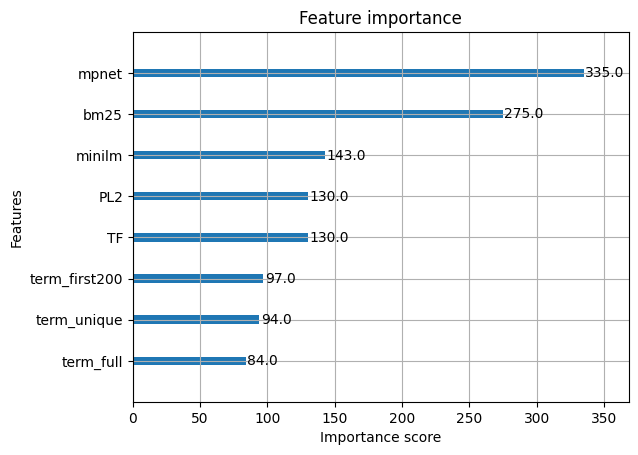

In [30]:
# Weight: Number of times a feature is used in splits.
# Gain: Average improvement in the loss function when the feature is used.
# Cover: Average number of samples affected by splits using the feature.

print(ltr_pipeline[-1].transform)
skle = ltr_pipeline[-1].learner
xgboo = skle.get_booster()
xgboo.feature_names = ["bm25","TF","PL2","term_unique","term_full","term_first200","minilm","mpnet"]
xgb.plot_importance(xgboo,importance_type = "weight")
plt.show()   

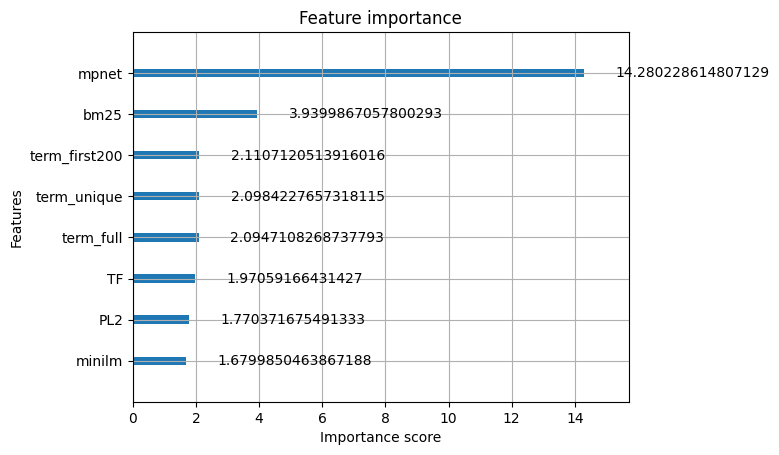

In [31]:
xgb.plot_importance(xgboo,importance_type = "gain")
plt.show()

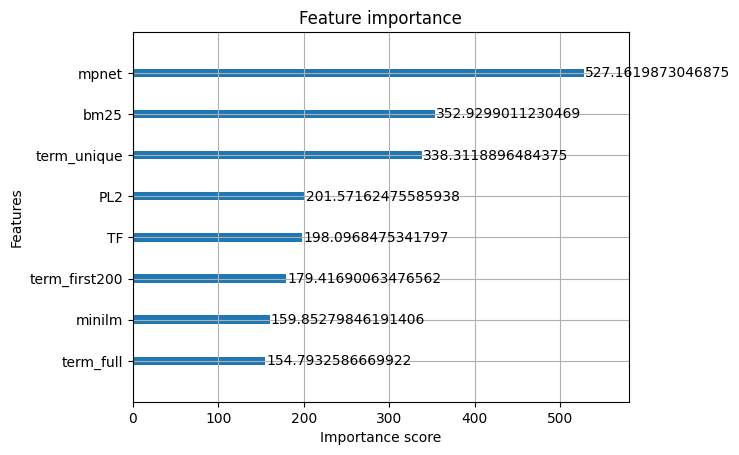

In [32]:
xgb.plot_importance(xgboo,importance_type = "cover")
plt.show()   

In [33]:
evalution = pt.Experiment([ltr_pipeline],valid_topics,valid_qrels, eval_metrics=["map", "ndcg_cut_10"])

df_eval = pd.DataFrame(evalution)
excel_path = "evaluation_results.xlsx"
sheet_name = "Results"

if os.path.exists(excel_path):
    existing = pd.read_excel(excel_path, sheet_name=sheet_name)
    combined = pd.concat([existing, df_eval], ignore_index=True)
    combined.to_excel(excel_path, sheet_name=sheet_name, index=False)
else:
    df_eval.to_excel(excel_path, sheet_name=sheet_name, index=False)

print(eval) 

03:13:08.954 [main] INFO org.terrier.querying.LocalManager -- Starting to execute query 651 - U S  ethnic population
03:13:08.984 [main] INFO org.terrier.querying.LocalManager -- running process TerrierQLParser
03:13:08.988 [main] INFO org.terrier.querying.LocalManager -- running process TerrierQLToControls
03:13:08.991 [main] INFO org.terrier.querying.LocalManager -- running process TerrierQLToMatchingQueryTerms
03:13:08.994 [main] INFO org.terrier.querying.LocalManager -- running process ApplyTermPipeline(termpipelines=Stopwords,PorterStemmer)
03:13:08.998 [main] INFO org.terrier.querying.LocalManager -- running process ApplyLocalMatching
03:13:09.005 [main] INFO org.terrier.querying.LocalManager -- ethnic { req=null, w=1.0, stats=null, models=[org.terrier.matching.models.BM25@6a10b263] tags=[firstmatchscore]} popul { req=null, w=1.0, stats=null, models=[org.terrier.matching.models.BM25@476ec9d0] tags=[firstmatchscore]} 
03:13:09.019 [main] INFO org.terrier.matching.PostingListManage